In [1]:
#Required Libraries
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None


#matplotlib
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import preprocessing, svm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, explained_variance_score
import sklearn
import matplotlib.dates as dates


#plotly library
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'plotly_dark'
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
import plotly.figure_factory as ff


import time
import seaborn as sns 
import datetime
from datetime import datetime, date, timedelta
from scipy import integrate, optimize
from scipy.integrate import odeint
import warnings
warnings.filterwarnings('ignore')

import os



F:\Anaconda\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# SIR Model

SIR model is one of the simplest compartment model consist of three compartments S for the number of susceptible, I for the number of infectious, and R for the number of recovered or deceased.

N: total population

S(t): number of people susceptible on day t

I(t): number of people infected on day t

R(t): number of people recovered on day t

β(“beta”): expected amount of people an infected person infects per day

D: number of days an infected person has and can spread the disease

γ(“Gamma”): the proportion of infected recovering per day (γ = 1/D)

R₀: the total number of people an infected person infects (R₀ = β / γ)

These systems are extremely sensitive to the initial parameters. Hence why it’s so hard to correctly model an emerging outbreak of a newer disease.

In [2]:
#Susceptible
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In [3]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

In [4]:
def SIR(N, b0, beta, gamma, hs):
    

    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

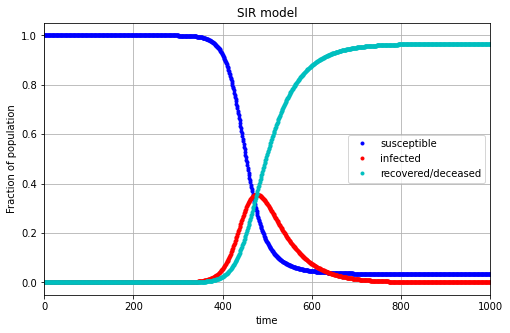

In [5]:
import matplotlib.pyplot as plt
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.grid()

# SEIHRD Model

Created the extended SIR model (SIR Extended Model: This model extended SIR with Exposed, Hospitalized and Dead Compartments)

## Data Preprocessing

In [6]:
df_country = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv')

In [7]:
df_country.head()

,Country_Region,Last_Update,Confirmed,Deaths,Recovered,Active,Delta_Confirmed,Delta_Recovered,Incident_Rate,People_Tested,People_Hospitalized,Province_State,FIPS,UID,iso3,Report_Date_String,Delta_Deaths
0,Afghanistan,1/22/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/22,0.0
1,Afghanistan,1/23/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/23,0.0
2,Afghanistan,1/24/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/24,0.0
3,Afghanistan,1/25/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/25,0.0
4,Afghanistan,1/26/20,0,0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,4,AFG,2020/01/26,0.0


In [8]:
df_country = df_country[df_country
                        ['Province_State'].isnull()]

In [9]:
df_country = df_country.query('Country_Region == "India"')
cols = ['Confirmed','Deaths','Recovered','Active']

In [10]:
df_country[['Country_Region']] = df_country[['Country_Region']].fillna('')

In [11]:
df_country[cols] = df_country[cols].fillna(0)

In [12]:
df_country = df_country.drop(['Country_Region','Last_Update','Delta_Recovered','Incident_Rate','People_Tested','People_Hospitalized','Province_State','FIPS','UID','iso3'], axis = 1)

In [13]:
df_country.head()

,Confirmed,Deaths,Recovered,Active,Delta_Confirmed,Report_Date_String,Delta_Deaths
24727,0,0,0.0,0.0,0.0,2020/01/22,0.0
24728,0,0,0.0,0.0,0.0,2020/01/23,0.0
24729,0,0,0.0,0.0,0.0,2020/01/24,0.0
24730,0,0,0.0,0.0,0.0,2020/01/25,0.0
24731,0,0,0.0,0.0,0.0,2020/01/26,0.0


In [14]:
population = float(1385567591) #India population
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = df_country.Confirmed.diff().fillna(0)
country_df = country_df[10:]
country_df['day_count'] = list(range(1,len(country_df)+1))

In [15]:
country_df.tail()

,ConfirmedCases,day_count
25035,44489.0,299
25036,43082.0,300
25037,41322.0,301
25038,41810.0,302
25039,38772.0,303


In [16]:
ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

In [17]:
ydata

array([0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       2.0000e+00, 0.0000e+00, 2.3000e+01, 2.0000e+00, 1.0000e+00,
       3.0000e+00, 5.0000e+00, 4.0000e+00, 1.3000e+01, 6.0000e+00,
       1.1000e+01, 9.0000e+00, 2.0000e+01, 1.1000e+01, 6.0000e+00,
       2.3000e+01, 1.4000e+01, 3.8000e+01, 5.0000e+01, 8.6000e+01,
       6.6000e+01, 1.0300e+02, 3.7000e+01, 1.2100e+02, 7.0000e+01,
       1.6000e+02, 1.0000e+02, 3.7000e+01, 2.2700e+02, 1.4600e+02,
       6.0100e+02, 5.4500e+02, 2.4000e+01, 5.1500e+02, 5.0600e+02,
       1.1900e+03, 5.3300e+02, 6.0500e+02, 8.0900e+02, 8.7300e+02,
       8.4800e+02, 7.5900e+02, 1.2480e+03, 1.0340e+03, 8.3500e

In [18]:
N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

In [19]:
def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec


In [20]:
def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

In [21]:
popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

Optimal parameters: beta = 1.0  and gamma =  1.0


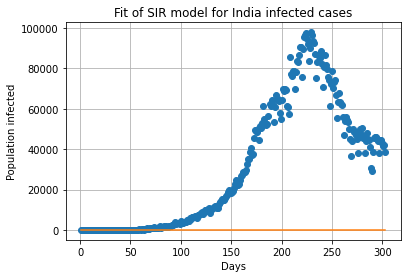

In [22]:
plt.plot(xdata, country_df.ConfirmedCases, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for India infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.grid()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

![India Cases](https://github.com/sreesh2411/DA_Project/blob/main/Screenshot%202020-11-30%20093112.png?raw=true)

We can notice the similarity between the plots. The second one is taken from google's live graph.

In [23]:
owid_covid_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv',parse_dates=["date"], skiprows=[1])
owid_covid_data = owid_covid_data.query('location=="US"' )
Data_To_Process =pd.DataFrame(columns=['date','deaths','cases'], data=owid_covid_data[['date', 'total_deaths','total_cases']].values)
Data_To_Process = Data_To_Process.sort_values(by='date', ascending=False)
Data_To_Process["deaths"] = Data_To_Process['deaths'].astype(str).astype(float)
data = Data_To_Process["deaths"].values[::-1]

In [24]:
dataprop =  Data_To_Process.fillna(0)

In [25]:
dataprop

,date,deaths,cases


In [26]:
data

array([], dtype=float64)

In [27]:
np.nan_to_num(data, copy=False)

array([], dtype=float64)

In [28]:
# parameters
gamma = 1.0/9.0
sigma = 1.0/3.0
Predict_For = 30
#India Population
N = 1385567591
#Data from OurWorldInData Data
beds_per_100k = 392

params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 180), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_H": (0.05, 0.01, 0.1), "prob_H_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  # form: {parameter: (initial guess, minimum value, max value)}

In [29]:
def Calculate_SEIHRD(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Hospital_Beds):
    S, E, I, H, R, D = y

    suspected = -beta(t) * I * S / N
    exposed = beta(t) * I * S / N - sigma * E
    infected = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    hosipitalized = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Hospital_Beds(t), H) - max(0, H-Hospital_Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Hospital_Beds(t), H)
    Recovered = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Hospital_Beds(t), H)
    Death = 1/7.5 * p_C_to_D * min(Hospital_Beds(t), H) + max(0, H-Hospital_Beds(t))
    return suspected, exposed, infected, hosipitalized, Recovered, Death

In [30]:
def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

In [31]:
def SEIHRDModel(days, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_H, prob_H_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
  
    
    def Hospital_Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    #Solve Differential Equations with ODEINT
    ret = odeint(Calculate_SEIHRD, y0, t, args=(beta, gamma, sigma, N, prob_I_to_H, prob_H_to_D, Hospital_Beds))
    S, E, I, H, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, H, R, D, R_0_over_time, Hospital_Beds, prob_I_to_H, prob_H_to_D


In [32]:
days = Predict_For + len(data)
y_data = np.concatenate((np.zeros(Predict_For), data))

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

In [33]:
def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_H, prob_H_to_D, s):
    ret = SEIHRDModel(days, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_H, prob_H_to_D, s)
    return ret[6][x]

In [34]:
#pip install lmfit

In [ ]:
import lmfit
mod = lmfit.Model(fitter)
#The special syntax kwargs in function definitions in python is used to pass a keyworded, variable-length argument list.
for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"
result = mod.fit(y_data, params, method="least_squares", x=x_data)
result.plot_fit(datafmt="-");

![](https://github.com/sreesh2411/DA_Project/blob/main/Screenshot%202020-11-30%20125807.png)

![SEIHRD Model](https://raw.githubusercontent.com/sreesh2411/DA_Project/main/Screenshot%202020-11-30%20125807.png)